In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [ ]:
gpu_device = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpu_device[0], 'GPU')

# Enable memory growth (optional)
tf.config.experimental.set_memory_growth(gpu_device[0], True)

In [ ]:
ds_name = "images"
ds_training_path = os.path.join(ds_name, "train")
ds_testing_path = os.path.join(ds_name, "test")

batch_size = 64
target_size = (224, 224)
random_seed = 55
num_classes = 4
epochs = 128

data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_gen = data_gen.flow_from_directory(
    ds_training_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=random_seed
)

valid_gen = data_gen.flow_from_directory(
    ds_testing_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

In [ ]:
base_model = tf.keras.applications.densenet.DenseNet201(weights='imagenet', 
                                               include_top=False, 
                                               input_shape=(224, 224, 3))


In [ ]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add your own classification layers on top of the pre-trained model
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)  

# Create the final model
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor for improvement
    patience=6,  # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)


# Train the model
callbacks=[early_stopping]

history= model.fit(
    train_gen,
    epochs=epochs,
    callbacks = callbacks,
    batch_size=batch_size, # Number
    validation_data=valid_gen
)

Epoch 1/128
1305/1305 [==============================] - 1126s 819ms/step - loss: 0.4446 - accuracy: 0.8423 - val_loss: 0.2396 - val_accuracy: 0.9184
Epoch 2/128
1305/1305 [==============================] - 321s 246ms/step - loss: 0.3428 - accuracy: 0.8774 - val_loss: 0.2935 - val_accuracy: 0.8688
Epoch 3/128
1305/1305 [==============================] - 320s 245ms/step - loss: 0.3213 - accuracy: 0.8851 - val_loss: 0.2651 - val_accuracy: 0.8915
Epoch 4/128
1305/1305 [==============================] - 335s 256ms/step - loss: 0.3082 - accuracy: 0.8901 - val_loss: 0.2064 - val_accuracy: 0.9308
Epoch 5/128
1305/1305 [==============================] - 331s 254ms/step - loss: 0.3007 - accuracy: 0.8922 - val_loss: 0.1970 - val_accuracy: 0.9298
Epoch 6/128
1305/1305 [==============================] - 323s 247ms/step - loss: 0.2960 - accuracy: 0.8939 - val_loss: 0.2183 - val_accuracy: 0.9143
Epoch 7/128
1305/1305 [==============================] - 318s 243ms/step - loss: 0.2933 - accuracy: 0.894

In [8]:
print(type(history))

<class 'keras.callbacks.History'>


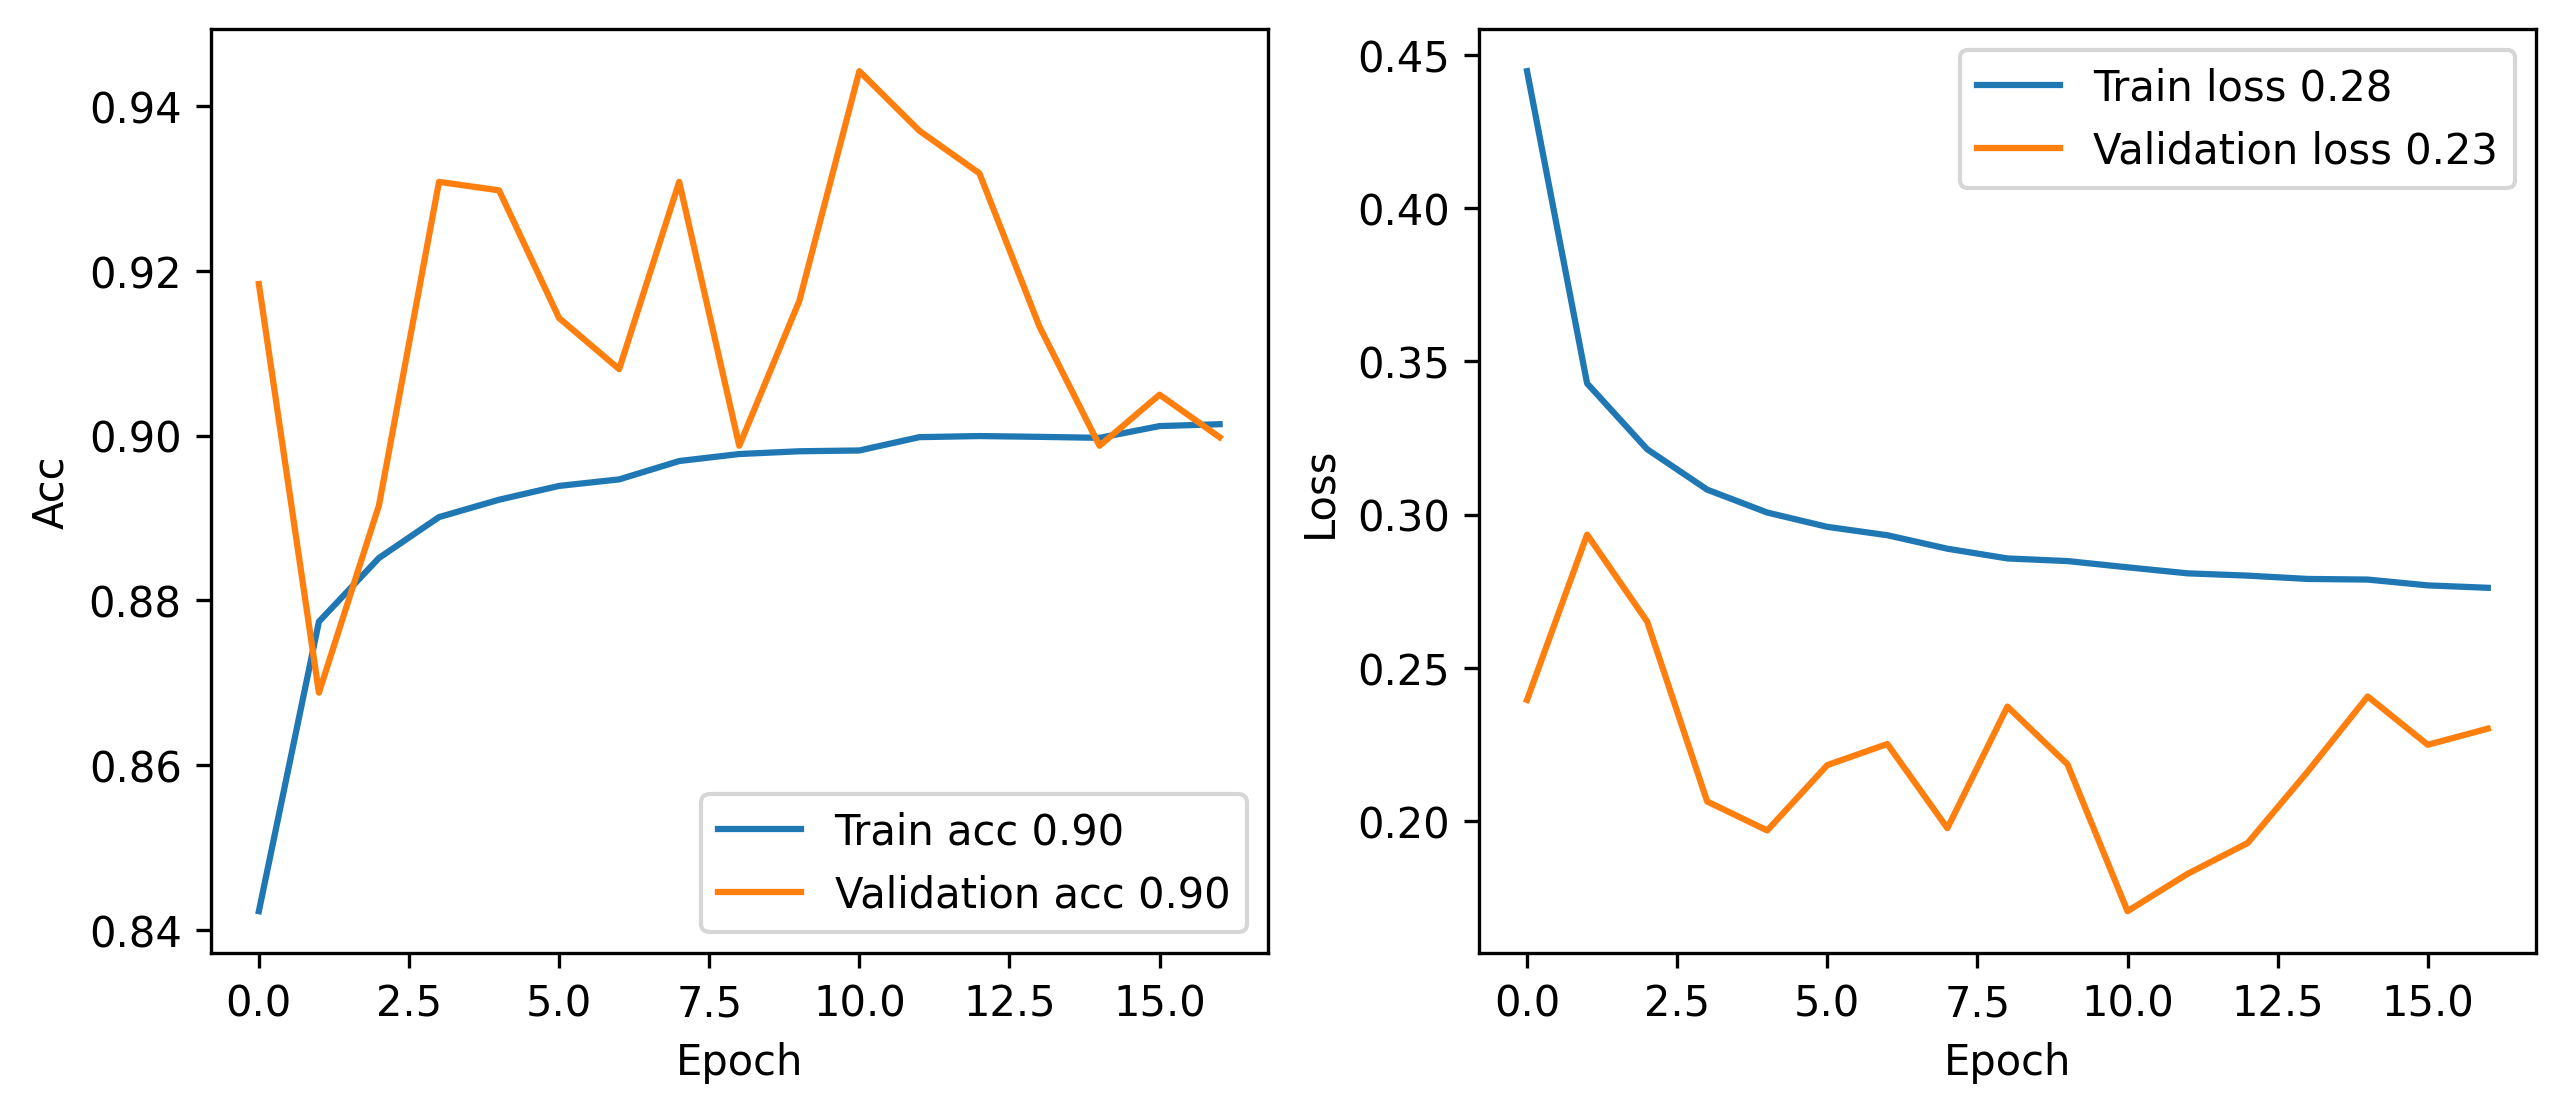

In [9]:
from helper import  Helper

_helper = Helper()
_helper.plot_train_and_val_curves(history)

16/16 [==============================] - 8s 218ms/step


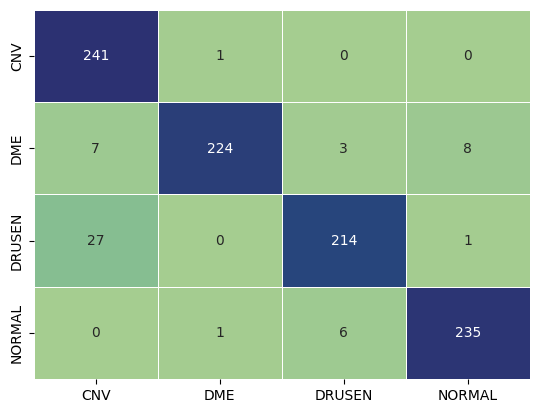

In [10]:
_helper.plot_confusion_matrix(model,valid_gen)

In [12]:
cm = _helper.get_confusion_matrix(model, valid_gen)
from confusion import Confusion
performances, _  = Confusion.getValues(cm)
performances

16/16 [==============================] - 4s 223ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       242
           1       0.99      0.93      0.96       242
           2       0.96      0.88      0.92       242
           3       0.96      0.97      0.97       242

    accuracy                           0.94       968
   macro avg       0.95      0.94      0.94       968
weighted avg       0.95      0.94      0.94       968

Confusion Matrix:
[[241   1   0   0]
 [  7 224   3   8]
 [ 27   0 214   1]
 [  0   1   6 235]]


,Value
Accuracy,0.944215
Sensitivity,0.944215
Specificity,0.981405
Precision,0.947568
FalsePositiveRate,0.018595
F1_score,0.944269
MatthewsCorrelationCoefficient,0.927133


16/16 [==============================] - 3s 204ms/step


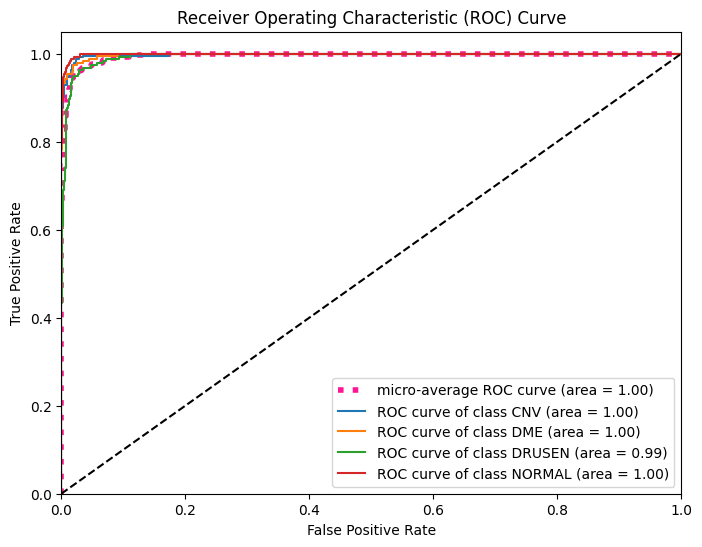

In [13]:
_helper.plot_roc_curve(model,valid_gen)

In [14]:
model.save("model.h5")